# Security Match Analysis

This notebook answers:
1) **How many matches did we get?**
2) **How are matches distributed across projects (org/repo)?**
3) **How are matches distributed across the regex patterns we used?**

**Inputs**: `hits.csv` produced by the scanning script.

**Outputs**: summary tables and bar charts (saved under `figs/`).

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ---- Configure the path to your CSV here ----
CSV_PATH = Path('out_security_scan/hits.csv')  # adjust if needed
FIG_DIR = Path('figs'); FIG_DIR.mkdir(exist_ok=True)

df = pd.read_csv(CSV_PATH)
print('Rows loaded:', len(df))
df.head(3)

Rows loaded: 85576


,org,repo,workflow_path,commit_sha,commit_date,matched_keywords,snapshot_relpath,prev_sha,diff_relpath,message
0,airbnb,AirMapView,.github/workflows/deploy_snapshot.yml,1c0675a913ac8fd349086c10d4a2f21922a9334f,2022-01-10T21:21:57Z,\bsecret(?:s)?\b,raw/airbnb/AirMapView/.github/workflows/deploy...,9463754d7d54307b28954d0d9d27d7733a9223e7,diffs/airbnb/AirMapView/.github_workflows_depl...,Use gradle.properties file for secrets.\n
1,airbnb,babel-plugin-inline-react-svg,.github/workflows/node.yml,baffab63e652060aa53964f88a39bd7e54c89eed,2023-02-17T16:51:17Z,\bprotect(?:ion|ed|ing)?\b,raw/airbnb/babel-plugin-inline-react-svg/.gith...,63611b5524c5a8cc97d5a21de0ffab86e5627d95,diffs/airbnb/babel-plugin-inline-react-svg/.gi...,"[actions] make a ""summary"" job, to require for..."
2,airbnb,DeepLinkDispatch,.github/workflows/deploy_snapshot.yml,e23411a2f5da6b9f33a1e8dfd27a70bd0c8a0c9e,2023-04-06T17:47:04Z,\bfix(?:es|ed)?\b|\bsecret(?:s)?\b,raw/airbnb/DeepLinkDispatch/.github/workflows/...,f0fdf7a23fc16654e5050d441741c603ca79b062,diffs/airbnb/DeepLinkDispatch/.github_workflow...,Fix snapshot release (#364)\n\n* Append secret...


## 1) Total matches

In [2]:
total_matches = len(df)
print('Total matches:', total_matches)

Total matches: 85576


## 2) Distribution across projects (org/repo)
We concatenate `org` and `repo` to define a project key.

In [3]:
df['project'] = df['org'].astype(str) + '/' + df['repo'].astype(str)
by_project = df.groupby('project').size().sort_values(ascending=False).rename('matches')
by_project_df = by_project.reset_index()
by_project_df.head(10)

,project,matches
0,Kubernetes/minikube,3241
1,github/policy-controller,1631
2,hashicorp/terraform-provider-aws,1053
3,microsoft/Qcodes,848
4,github/codeql-action,845
5,Kubernetes/release,711
6,spring-projects/spring-aot-smoke-tests,679
7,microsoft/mfcmapi,551
8,mozilla/neqo,546
9,dotnet/docs,513


WindowsPath('figs/matches_by_project_top20.png')

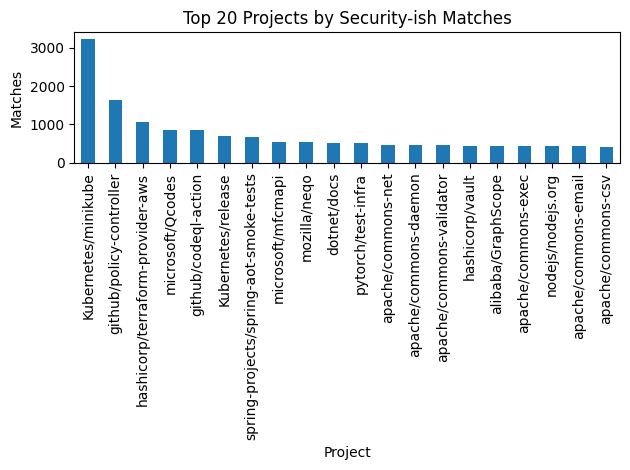

In [4]:
# Plot top 20 projects by count
top_n = 20
plt.figure()
by_project.head(top_n).plot(kind='bar')
plt.title(f'Top {top_n} Projects by Security-ish Matches')
plt.xlabel('Project')
plt.ylabel('Matches')
plt.tight_layout()
fig_path = FIG_DIR / 'matches_by_project_top20.png'
plt.savefig(fig_path)
fig_path

Full table of matches per project:

In [5]:
by_project_df

,project,matches
0,Kubernetes/minikube,3241
1,github/policy-controller,1631
2,hashicorp/terraform-provider-aws,1053
3,microsoft/Qcodes,848
4,github/codeql-action,845
...,...,...
3200,google/autofdo,1
3201,google/badwolf,1
3202,airbnb/omniduct,1
3203,airbnb/swift,1


## 3) Distribution across regex patterns
The `matched_keywords` column contains a `|`-separated list of regex patterns matched in the commit message. 
We will split and explode it to count occurrences per pattern.

In [6]:
df_kw = df.copy()
df_kw['matched_keywords'] = df_kw['matched_keywords'].fillna('')
df_kw = df_kw[df_kw['matched_keywords'].astype(str).str.len() > 0]
df_kw = df_kw.assign(pattern=df_kw['matched_keywords'].str.split('|')).explode('pattern')
df_kw['pattern'] = df_kw['pattern'].str.strip()
df_kw = df_kw[df_kw['pattern'] != '']

by_pattern = df_kw.groupby('pattern').size().sort_values(ascending=False).rename('matches')
by_pattern_df = by_pattern.reset_index()
by_pattern_df.head(20)

,pattern,matches
0,ing)?\b,71745
1,ed,45630
2,\bbump(?:s,44979
3,\bdependabot\b,38888
4,ed)?\b,25299
5,\bfix(?:es,23220
6,\bpatch(?:ed,17797
7,\bupgrade\b,5196
8,ning)?\b,4895
9,\bpin(?:ned,4743


WindowsPath('figs/matches_by_regex_top20.png')

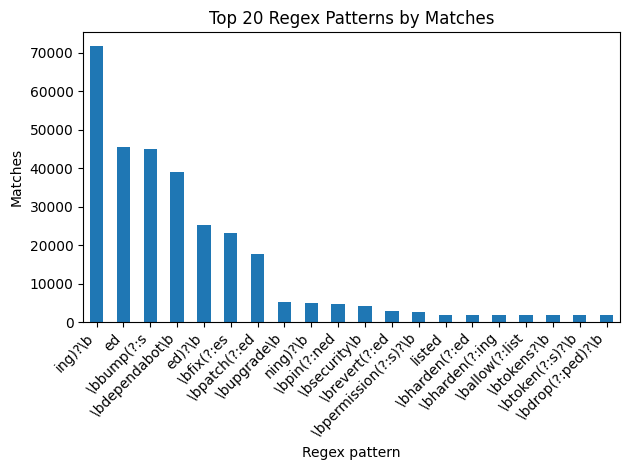

In [7]:
# Plot top 20 patterns by count
top_n = 20
plt.figure()
by_pattern.head(top_n).plot(kind='bar')
plt.title(f'Top {top_n} Regex Patterns by Matches')
plt.xlabel('Regex pattern')
plt.ylabel('Matches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
fig_path = FIG_DIR / 'matches_by_regex_top20.png'
plt.savefig(fig_path)
fig_path

### Optional: Cross-tab — projects × patterns (sparse)
This gives a sense of which projects matched which patterns. For large datasets, it can be wide.

In [8]:
cross = df_kw.pivot_table(index='project', columns='pattern', values='commit_sha', aggfunc='count', fill_value=0)
cross.head(10)

pattern,@[0-9a-fA-F]{40},"@v\d+(?:\.\d+){0,2}",\b(leak,"\bCVE[- ]?\d{4}-\d{3,7}\b",\bGHSA[-\w]+\b,\bGITHUB_TOKEN\b,\ballow(?:list,\bauth(?:n,\bbackport(?:ed,\bbump(?:s,...,ning)?\b,none)\b,orization)?\b,s,s)?\b,to sha)\b,ure)\b,write,write)\b,z
project,,,,,,,,,,,,,,,,,,,,,
Azure/AKS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
Azure/AppConfiguration-DotnetProvider,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
Azure/AppService,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Azure/Azure-DataFactory,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Azure/Azurite,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Azure/WALinuxAgent,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Azure/acr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Azure/autorest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Azure/autorest.csharp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Save summary tables to CSV (for the repo)

In [9]:
by_project_df.to_csv('summary_by_project.csv', index=False)
by_pattern_df.to_csv('summary_by_regex.csv', index=False)
cross.to_csv('summary_cross_projects_x_regex.csv')
print('Wrote summary_by_project.csv, summary_by_regex.csv, summary_cross_projects_x_regex.csv')

Wrote summary_by_project.csv, summary_by_regex.csv, summary_cross_projects_x_regex.csv
